In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

dF_stores=pd.read_csv('stores.csv')
dF_products=pd.read_csv('products.csv')
dF_customers=pd.read_csv('customers.csv')

raw_data = pd.read_csv('tickets.csv')
raw_data['datekey']=pd.to_datetime(raw_data['datekey'],format="%Y-%m-%d")

## Valor Monetario 

In [78]:
M_data = pd.DataFrame(raw_data.groupby(['customerid'])['extendedamount'].sum())
M_data = M_data.sort_values('extendedamount')
M_data.head()

,extendedamount
customerid,
77340000000163060,0.32
77000000175054667,0.33
77340000023117043,0.57
77340000010700461,0.69
77340000000549993,0.69


In [79]:
M_data['score'] = 1

for i in range(len(M_data)):
    if i > len(M_data) / 5 * 4:
        M_data.iloc[i, 1] = 5
    elif i > len(M_data) / 5 * 3:
        M_data.iloc[i, 1] = 4
    elif i > len(M_data) / 5 * 2:
        M_data.iloc[i, 1] = 3
    elif i > len(M_data) / 5:
        M_data.iloc[i, 1] = 2

In [80]:
M_data.score.value_counts().sort_values()

5    4178
4    4179
3    4179
2    4179
1    4179
Name: score, dtype: int64

## Frecuencia

In [81]:
F_data = raw_data[['ticketid', 'customerid']].copy().drop_duplicates()
F_data['ones'] = 1
F_data = pd.DataFrame(F_data.groupby('customerid')['ones'].sum())
F_data.ones.value_counts().sort_values()

38       1
33       1
80       1
47       1
40       1
51       1
31       1
35       1
32       2
37       2
30       3
29       6
26       6
25       6
27       7
28       8
24       9
23      11
22      18
20      18
21      20
18      25
19      28
17      33
16      45
15      56
14      92
13     116
12     141
11     193
10     265
9      336
8      418
7      599
6      869
5     1186
4     1712
3     2565
2     4369
1     7722
Name: ones, dtype: int64

__Cada grupo debería contener 4179 individuos pero como el número de clientes que han comprado una sola vez excede ente número, este grupo deberá ser mas grande para que tenga sentido, por lo que el criterio de asignación de grupos será el siguiente:__

__frecuencia 1 -> grupo 1 -> 7722 individuos  
frecuencia 2 -> grupo 2 -> 4369 individuos  
frecuencia 3+ -> grupo 3 -> 4277 individuos  
frecuencia 5+ -> grupo 4 -> 2654 individuos  
frecuencia 8+ -> grupo 5 -> 1872 individuos__

In [82]:
F_data['score'] = 5
F_data.loc[F_data.ones == 1, 'score'] = 1
F_data.loc[F_data.ones == 2, 'score'] = 2
F_data.loc[(F_data.ones == 3) | (F_data.ones == 4), 'score'] = 3
F_data.loc[(F_data.ones >= 5) & (F_data.ones <= 7), 'score'] = 4

In [83]:
F_data.score.value_counts().sort_values()

5    1872
4    2654
3    4277
2    4369
1    7722
Name: score, dtype: int64

## Recencia

In [84]:
lastDate = raw_data['datekey'].max()
R_data = raw_data.groupby('customerid').agg({'datekey': lambda x: (lastDate - x.max()).days})
R_data.datekey.value_counts().sort_values()

65     294
85     294
70     313
39     322
75     329
78     331
86     364
79     371
77     371
44     390
84     399
49     400
40     401
57     401
58     411
56     421
33     519
30     524
37     539
28     553
22     663
23     757
19     759
14     916
12    1354
7     1417
16    1422
9     1577
5     1976
0     2106
Name: datekey, dtype: int64

__El criterio de asignación de grupos será el siguiente:__

__recencia < 6 -> grupo 5 -> 4082 individuos  
6 < recencia < 13  -> grupo 4 -> 4348 individuos    
13 < recencia < 26  -> grupo 3 -> 4517 individuos  
26 < recencia < 57  -> grupo 2 -> 4069 individuos  
recencia >= 57  -> grupo 1 -> 3878 individuos__

In [85]:
R_data['score'] = 5
R_data.loc[(R_data.datekey > 6) & (R_data.datekey < 13), 'score'] = 4
R_data.loc[(R_data.datekey > 13) & (R_data.datekey < 26), 'score'] = 3
R_data.loc[(R_data.datekey > 26) & (R_data.datekey < 57), 'score'] = 2
R_data.loc[R_data.datekey >= 57, 'score'] = 1

In [86]:
R_data.score.value_counts().sort_values()

1    3878
2    4069
5    4082
4    4348
3    4517
Name: score, dtype: int64

In [87]:
RFM_scores = pd.DataFrame()
RFM_scores['R'] = R_data['score']
RFM_scores['F'] = F_data['score']
RFM_scores['M'] = M_data['score']
RFM_scores.head()

,R,F,M
customerid,,,
77000000050003334,2,3,5
77000000050010221,2,1,2
77000000050012258,4,4,5
77000000050014586,4,4,3
77000000050014974,2,4,4


## Clustering

In [88]:
from sklearn.cluster import KMeans

wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(RFM_scores)
    wcss.append(kmeans.inertia_)

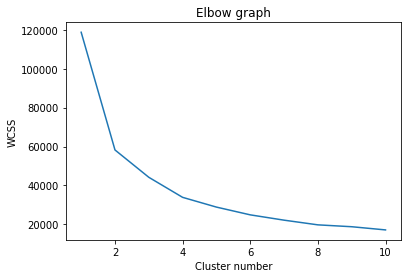

In [89]:
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

__2 y 4 parecen ser los mejores candidatos__

In [90]:
RFM_data = pd.DataFrame()
RFM_data['R'] = R_data['datekey']
RFM_data['F'] = F_data['ones']
RFM_data['M'] = M_data['extendedamount']

In [91]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
cluster = kmeans.fit_predict(RFM_scores)

In [92]:
RFM_data['cluster'] = cluster
RFM_data.head()

,R,F,M,cluster
customerid,,,,
77000000050003334,37,3,148.96,3
77000000050010221,30,1,33.30,2
77000000050012258,9,6,138.79,1
77000000050014586,12,5,59.79,1
77000000050014974,44,6,97.09,3


Text(0.5, 0, 'Monetary')

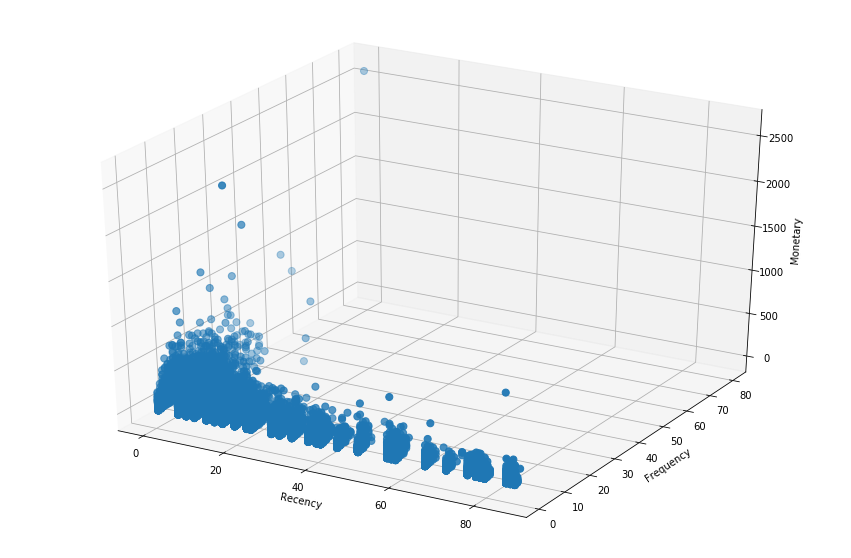

In [93]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(RFM_data.R, RFM_data.F, RFM_data.M, s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

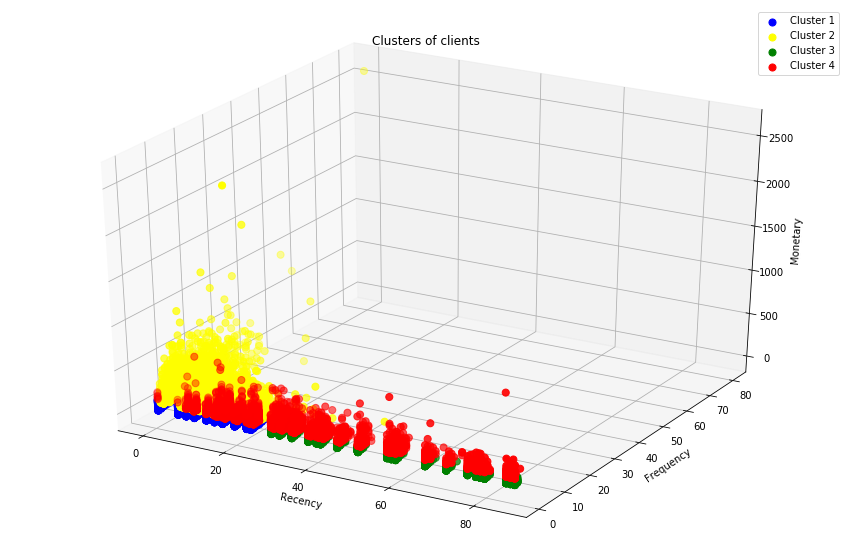

In [94]:
fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'yellow', 'green', 'red']

for i in range(0,4):
    dx.scatter(RFM_data[RFM_data.cluster == i].R, 
               RFM_data[RFM_data.cluster == i].F, 
               RFM_data[RFM_data.cluster == i].M, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

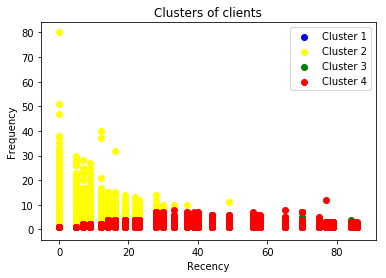

In [95]:
c1 = RFM_data[RFM_data.cluster == 0]
c2 = RFM_data[RFM_data.cluster == 1]
c3 = RFM_data[RFM_data.cluster == 2]
c4 = RFM_data[RFM_data.cluster == 3]

plt.scatter(c1.R, c1.F, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.R, c2.F, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.R, c3.F, c = 'green', label = 'Cluster 3')
plt.scatter(c4.R, c4.F, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()

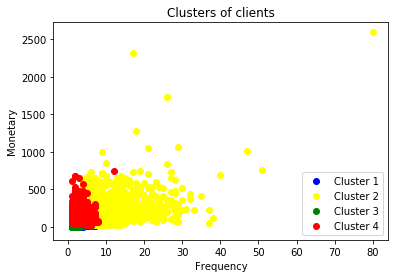

In [96]:
c1 = RFM_data[RFM_data.cluster == 0]
c2 = RFM_data[RFM_data.cluster == 1]
c3 = RFM_data[RFM_data.cluster == 2]
c4 = RFM_data[RFM_data.cluster == 3]

plt.scatter(c1.F, c1.M, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.F, c2.M, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.F, c3.M, c = 'green', label = 'Cluster 3')
plt.scatter(c4.F, c4.M, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()

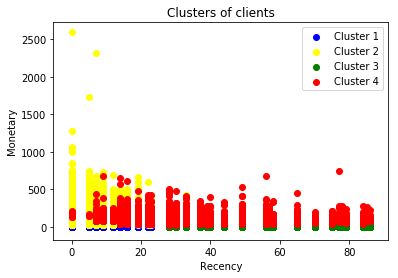

In [97]:
c1 = RFM_data[RFM_data.cluster == 0]
c2 = RFM_data[RFM_data.cluster == 1]
c3 = RFM_data[RFM_data.cluster == 2]
c4 = RFM_data[RFM_data.cluster == 3]

plt.scatter(c1.R, c1.M, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.R, c2.M, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.R, c3.M, c = 'green', label = 'Cluster 3')
plt.scatter(c4.R, c4.M, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()

In [104]:
RFM_scores.head()

data_M = dF_customers.merge(RFM_data, on="customerid", how = 'inner')

In [105]:
data_M=data_M[data_M["gender"]=="M"]
data_M=data_M.set_index(['customerid'])


In [106]:
data_M=data_M.drop(["isocountrycode","isocountrycode","registrationdate","regularstoreid","unregistrationdate","zipcode","age","gender"],1)

In [107]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
cluster = kmeans.fit_predict(data_M)
data_M['cluster'] = cluster
data_M.head()

,R,F,M,cluster
customerid,,,,
77340000025935766,33,1,14.88,1
77340000025921798,12,3,25.55,1
77340000025908606,0,4,318.53,2
77340000025876402,0,20,178.32,0
77340000025871940,28,1,41.14,1


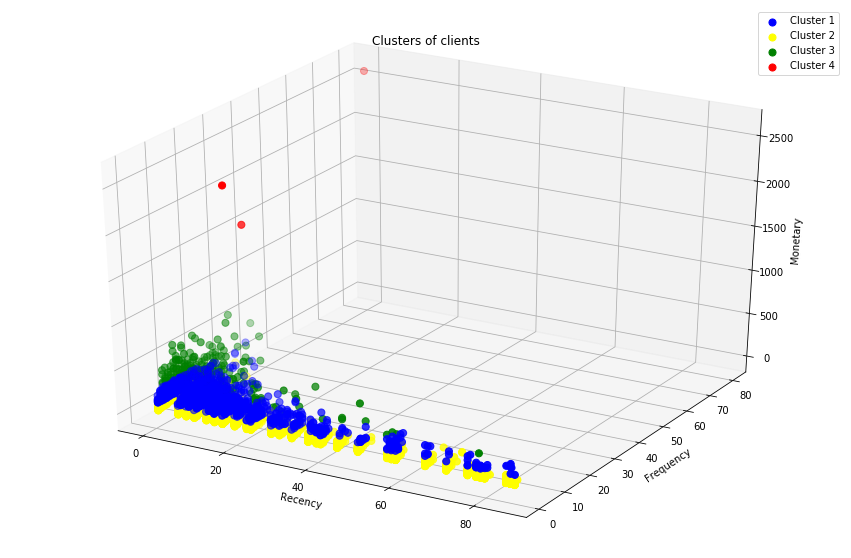

In [108]:
fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'yellow', 'green', 'red']

for i in range(0,4):
    dx.scatter(data_M[data_M.cluster == i].R, 
               data_M[data_M.cluster == i].F, 
               data_M[data_M.cluster == i].M, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

In [115]:
data_F = dF_customers.merge(RFM_data, on="customerid", how = 'inner')
data_F=data_F[data_F["gender"]=="F"]
data_F=data_F.set_index(['customerid'])
data_F=data_F.drop(["isocountrycode","isocountrycode","registrationdate","regularstoreid","unregistrationdate","zipcode","age","gender"],1)

In [116]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
cluster = kmeans.fit_predict(data_F)
data_F['cluster'] = cluster
data_F.head()

,R,F,M,cluster
customerid,,,,
77340000025940422,9,3,24.45,1
77340000025935281,7,1,12.85,1
77340000025926842,9,6,112.77,0
77340000025924514,12,3,60.28,1
77340000025912777,0,12,186.99,3


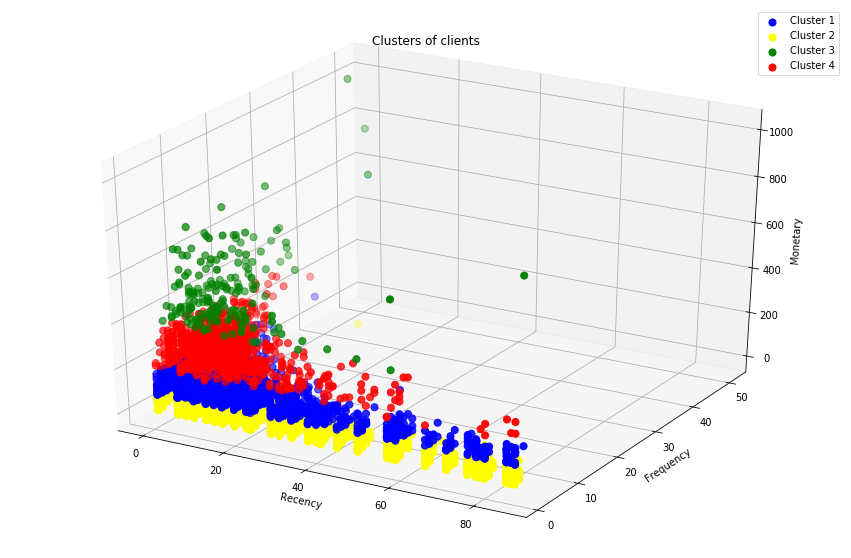

In [118]:
fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'yellow', 'green', 'red']

for i in range(0,4):
    dx.scatter(data_F[data_F.cluster == i].R, 
               data_F[data_F.cluster == i].F, 
               data_F[data_F.cluster == i].M, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()